In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt #zaman, saat ve tarihlerle ilgili işlemler yapmamızı sağlayar
import numpy as np
from keras.layers import Dense,LSTM,Embedding,Dropout
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Colabnot/TWTR.csv')

In [4]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-09-10,62.950001,63.369999,61.470001,61.560001,61.560001,7032100
1,2021-09-13,61.299999,61.410000,58.450001,59.660000,59.660000,16851600
2,2021-09-14,60.070000,60.700001,59.490002,60.189999,60.189999,8240100
3,2021-09-15,60.099998,61.910000,59.639999,61.840000,61.840000,13074500
4,2021-09-16,61.529999,62.610001,60.930000,62.290001,62.290001,9918700


In [5]:
#datanın sütunları ve veri tipleri
data.info

<bound method DataFrame.info of            Date       Open       High        Low      Close  Adj Close  \
0    2021-09-10  62.950001  63.369999  61.470001  61.560001  61.560001   
1    2021-09-13  61.299999  61.410000  58.450001  59.660000  59.660000   
2    2021-09-14  60.070000  60.700001  59.490002  60.189999  60.189999   
3    2021-09-15  60.099998  61.910000  59.639999  61.840000  61.840000   
4    2021-09-16  61.529999  62.610001  60.930000  62.290001  62.290001   
..          ...        ...        ...        ...        ...        ...   
247  2022-09-02  38.860001  39.009998  38.290001  38.630001  38.630001   
248  2022-09-06  38.619999  39.090000  38.060001  38.650002  38.650002   
249  2022-09-07  39.299999  41.250000  39.299999  41.200001  41.200001   
250  2022-09-08  41.000000  42.169998  40.980000  41.849998  41.849998   
251  2022-09-09  41.880001  42.299999  41.509998  42.189999  42.189999   

       Volume  
0     7032100  
1    16851600  
2     8240100  
3    13074500  

In [6]:
#boyutu
data.shape

(252, 7)

In [7]:
#boş değer kontrolü
data.isna().sum() # boş değer yok

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
#görselleştirme yapalım(hatayı henüz çözemedim)

#plt.figure(figsize=(16,8))
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
#x_date = [dt.datetime.strptime(d,'Y-%m-%d').date() for d in data.index.values]

#plt.plot(x_date, data['High'], label='High')
#plt.plot(x_date, data['Low'], label='Low')
#plt.ylabel('usd')
#plt.legend()
#plt.gcf().autofmt_xdate()
#plt.show

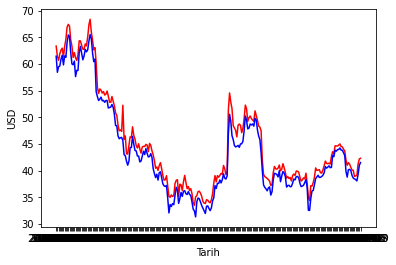

In [10]:
#veriyi görselleştirelim

plt.plot(data.Date,data.High,color="red") 

plt.plot(data.Date,data.Low,color="blue")

plt.xlabel("Tarih")

plt.ylabel("USD")

plt.show()

In [11]:
#veri ön işleme 
target_y = data['Close']
x_feat = data.iloc[:,0:3]

In [12]:
#zaman serisini feature olarak kullanmamız durumunda ayırma işlemi yapmamız gerekir.
#date sütunundan çokça sayıda feature üretebiliyoruz gereksinim doğrultusunda.
#ValueError: could not convert string to float: '2022-04-07   SÜREKLİ ALDIĞIM BU HATANIN ÇZÖÜMÜ OLDU.
def timestamp_changer(df,date_time):
    df[date_time] = pd.to_datetime(df[date_time]).dt.strftime('%d.%m.%Y.%H:%M')
    df[date_time] = pd.to_datetime(df[date_time])
    years = df[date_time].dt.year
    months = df[date_time].dt.month
    day_of_months = df[date_time].dt.day
    features = pd.DataFrame({
    'year' : years,
    'month' : months,
    'day_of_month' : day_of_months
    })
    return features
def change_timestamp(df,date_time):
    df_timestamp = timestamp_changer(df,date_time=date_time)
    for i in df_timestamp.columns:
        for j in range(len(df_timestamp.columns)):
            try:
                df.insert(j,column=i,value=df_timestamp[i])
                continue
            except:
                continue

change_timestamp(data,'Date')

In [13]:
#düşüreceğimiz sınıfın özelliklerini farklı kolonlara atadık. Bu sınıfın bir özelliği kalmadı. O yüzden sildik
data.drop('Date',axis=1,inplace=True) 

In [14]:
#date için kontrol ettik
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   day_of_month  252 non-null    int64  
 1   month         252 non-null    int64  
 2   year          252 non-null    int64  
 3   Open          252 non-null    float64
 4   High          252 non-null    float64
 5   Low           252 non-null    float64
 6   Close         252 non-null    float64
 7   Adj Close     252 non-null    float64
 8   Volume        252 non-null    int64  
dtypes: float64(5), int64(4)
memory usage: 17.8 KB


In [23]:
from sklearn.preprocessing import MinMaxScaler
 
# scale features
scaler = MinMaxScaler()
model=scaler.fit(data)
scaled_data=model.transform(data)
 
# print scaled features
print(scaled_data)

[[0.26666667 0.81818182 0.         ... 0.83735634 0.83735634 0.00820121]
 [0.4        0.72727273 0.         ... 0.78275861 0.78275861 0.04545342]
 [0.43333333 0.72727273 0.         ... 0.79798847 0.79798847 0.012784  ]
 ...
 [0.26666667 0.54545455 1.         ... 0.25229892 0.25229892 0.05092432]
 [0.26666667 0.63636364 1.         ... 0.27097699 0.27097699 0.02639996]
 [0.26666667 0.72727273 1.         ... 0.28074713 0.28074713 0.00952787]]


In [28]:
t_y = data['Close']
x_feat = data.iloc[:,0:3].values

In [29]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range =(-1, 1))
  
# Scaled feature
#x_after_min_max_scaler = min_max_scaler.fit_transform(x_feat)
  
#print ("\nAfter min max Scaling : \n", x_after_min_max_scaler)
#hisse senedi farklı günlerde maksimuma çıkabilir veya en aza indirilebilir ve bu değerleri başkalarını etkilemek için kullanmak pek iyi olmayabilir.(min-max)
  
""" Standardisation """
  
Standardisation = preprocessing.StandardScaler()
  
# Scaled feature
x_after_Standardisation = Standardisation.fit_transform(x_feat)
  
print ("\nAfter Standardisation : \n", x_after_Standardisation)


After Standardisation : 
 [[-0.7490783   1.00113938 -1.47982209]
 [-0.29476366  0.71015077 -1.47982209]
 [-0.181185    0.71015077 -1.47982209]
 [-0.06760634  0.71015077 -1.47982209]
 [ 0.04597231  0.71015077 -1.47982209]
 [ 0.15955097  0.71015077 -1.47982209]
 [ 0.50028695  0.71015077 -1.47982209]
 [ 0.61386561  0.71015077 -1.47982209]
 [ 0.72744427  0.71015077 -1.47982209]
 [ 0.84102293  0.71015077 -1.47982209]
 [ 0.95460159  0.71015077 -1.47982209]
 [ 1.29533757  0.71015077 -1.47982209]
 [ 1.40891623  0.71015077 -1.47982209]
 [ 1.52249489  0.71015077 -1.47982209]
 [ 1.63607355  0.71015077 -1.47982209]
 [-0.63549964 -1.6177581  -1.47982209]
 [-0.63549964 -0.74479227 -1.47982209]
 [-0.63549964 -0.45380366 -1.47982209]
 [-0.63549964 -0.16281506 -1.47982209]
 [-0.63549964  0.12817355 -1.47982209]
 [-0.63549964  0.41916216 -1.47982209]
 [-0.63549964  1.29212799 -1.47982209]
 [-0.63549964  1.5831166  -1.47982209]
 [-0.29476366  1.00113938 -1.47982209]
 [-0.181185    1.00113938 -1.47982209

In [37]:
#scikit-learn tarafından sağlanan train_test_split'ten farklı bir yaklaşım lazım.(kaynağı bul ve detayı yaz)
def lstm_split(scaled_data, n_steps):
  X,y = [], []
  for i in range(len(scaled_data)-n_steps+1):
    X.append(scaled_data[i:i+n_steps,:-1])
    y.appened(scaled_data[i+n_steps-1,-1])

  return np.array(X), np.array(y)

In [39]:
"""!pip install numpy
x1, y1 = lstm_split(scaled_data.values, n_steps=2)

train=0.8
split= int(np.ceil(len(x1)*train))
date_index = scaled_data.date_index

x_train, x_test = x1[:split], x1[split:]
y_train, y_test = y1[:split], y1[split:]
x_train_date, x_test_date = date_index[:split], date_index[split:]

print(x1.shape, x_train.shape, x_test.shape, y_test.shape)"""

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


AttributeError: ignored

In [ ]:
"""Uzun kısa süreli bellek (LSTM), değerleri rastgele aralıklarla hatırlayan bir tekrarlayan sinir ağı (RNN) bir mimarisidir."""
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(x_train.shape[1], x_train.shape[2]),
              activation='relu', return_sequences=True))
lstm.add(Dense(1))
lstm.compile(loss ='mean_squared_error', optimizer='adam')
lstm.summary()

In [ ]:
history=lstm.fit(x_train, y_train,
                 epochs=100, batch_size=4,
                 verbose=2, shuffle=False)

In [ ]:
#test setinde değerlendirme
y_pred = lstm.predict(x_test)

In [ ]:
#performans için RMSE , MAPE değerlerine bakarız

rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("RSME: ", rmse)
print("MAPE: ", mape)